<a href="https://colab.research.google.com/github/jfink09/Deep-Learning/blob/main/FINAL_MAGNITUDE_PREDICTIONS_NO_TRANSFORMATIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
ak_train = pd.read_excel('AK TRAINSET.xlsx')
ak_test = pd.read_excel('AK TESTSET.xlsx')
our_train = pd.read_excel('OG TRAINSET.xlsx')
our_test = pd.read_excel('OG TESTSET.xlsx')

In [3]:
len(ak_train),len(ak_test),len(our_test),len(our_train)

(15601, 3901, 3901, 15601)

In [4]:
ak_test

,Age,Astig F (D):,Axis F:,Anterior Cyl X (deconstructed),Anterior Cyl Y (deconstructed),Total Cyl X (regression),Total Cyl Y (regression),Total Corneal Axis Intermediate,Total Corneal Cyl (reconstructed),Total Corneal Axis Final (reconstructed),Astig Total (D):
0,35,1.2,97.6,-1.158020,-0.314627,-0.564326,-0.284232,13.366437,0.631864,103.366437,0.818633
1,52,1.5,87.2,-1.492841,0.146374,-0.874371,0.145421,-4.721355,0.886381,85.278645,1.002627
2,35,1.1,17.1,0.909789,0.618292,1.350464,0.585248,11.715180,1.471825,11.715180,1.181004
3,35,0.8,166.3,0.710252,-0.368160,1.165694,-0.334125,-7.996995,1.212634,172.003005,0.971290
4,58,1.7,88.6,-1.697970,0.083045,-1.064321,0.086398,-2.320441,1.067822,87.679559,1.306424
...,...,...,...,...,...,...,...,...,...,...,...
3896,30,1.2,101.2,-1.109455,-0.457284,-0.519356,-0.417189,19.387148,0.666166,109.387148,0.703254
3897,30,1.3,74.1,-1.104861,0.685043,-0.515101,0.647460,-25.747611,0.827365,64.252389,0.932877
3898,56,0.7,96.9,-0.679794,-0.166973,-0.121489,-0.146619,25.177364,0.190412,115.177364,0.304114
3899,56,0.7,60.2,-0.354224,0.603760,0.179989,0.571704,36.262246,0.599367,36.262246,0.483569


In [5]:
import numpy as np
actual_values = ak_test['Astig Total (D):'].to_numpy()
predicted_values = ak_test['Total Corneal Cyl (reconstructed)'].to_numpy()
from math import sqrt

rmse_ak = sqrt(np.mean((actual_values - predicted_values)**2))
print("RMSE:", rmse_ak)

RMSE: 0.22583451684215783


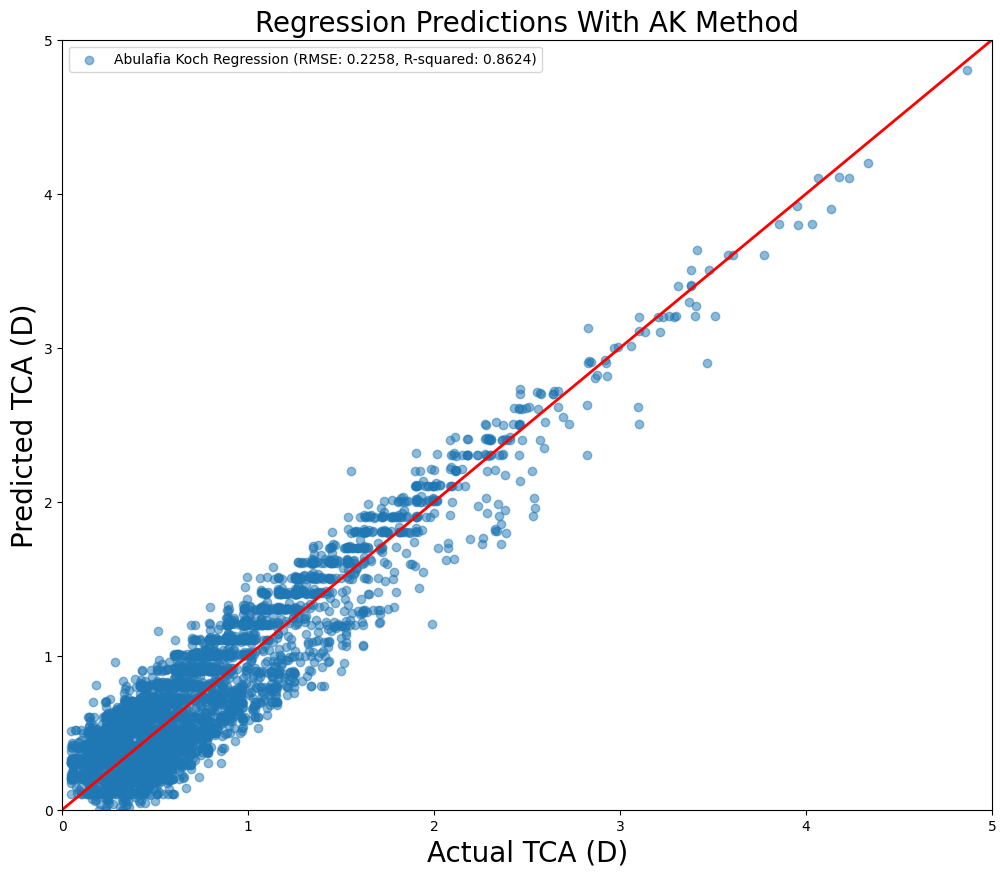

In [6]:
from sklearn.metrics import r2_score

# Calculate R-squared on test data
ak_r_squared = r2_score(ak_test['Total Corneal Cyl (reconstructed)'], ak_test['Astig Total (D):'])

legend_label = f"Abulafia Koch Regression (RMSE: {rmse_ak:.4f}, R-squared: {ak_r_squared:.4f})"

fig = plt.subplots(figsize=(12,10))

# plot actual vs predicted values
plt.scatter(ak_test['Total Corneal Cyl (reconstructed)'], ak_test['Astig Total (D):'], alpha=0.5, label=legend_label) #AK DATA

x_value = range(11)

# Calculate y values as equal to x
y_value = [val for val in x_value]

# Plot the line graph
plt.plot(x_value, y_value, color='#FF0000', linewidth=2)

plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('Actual TCA (D)',size=20)
plt.ylabel('Predicted TCA (D)',size=20)
#plt.title('Regression Predictions Without Deep Learning',size=20)
plt.title('Regression Predictions With AK Method',size=20)
plt.legend()
plt.show()

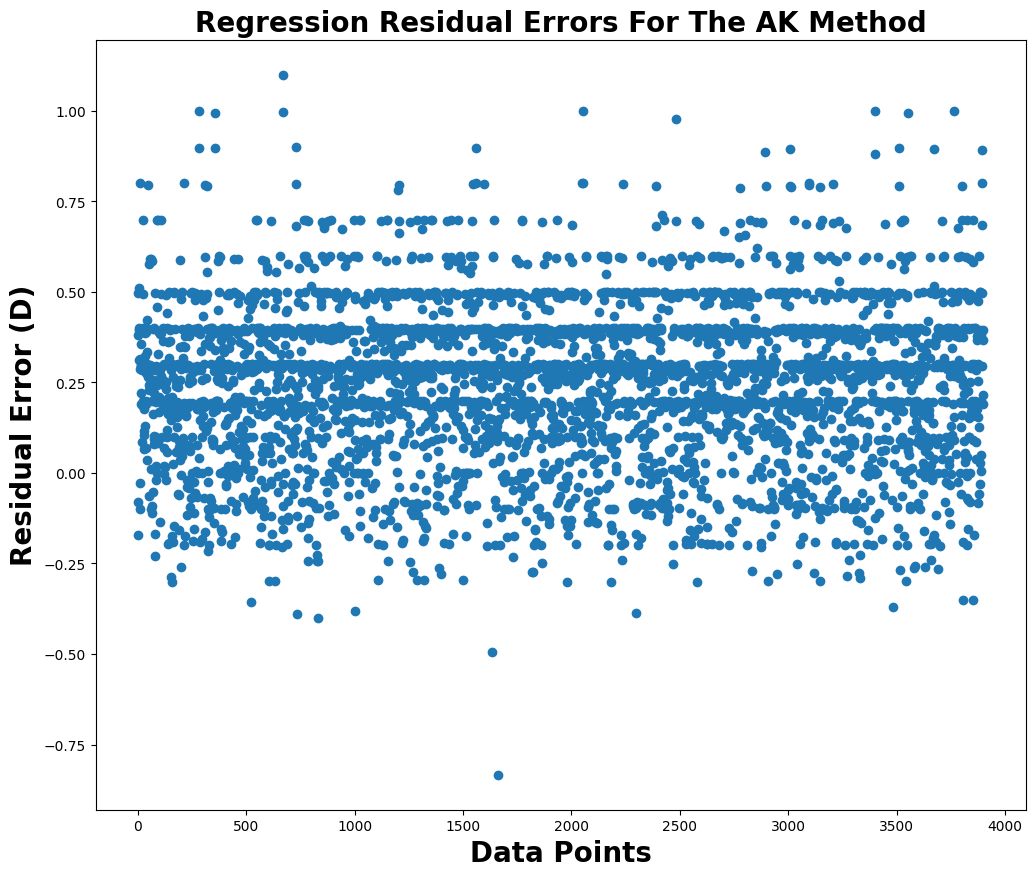

In [7]:
residuals = [ak_test['Astig F (D):'][i] - ak_test['Astig Total (D):'][i] for i in range(len(ak_test['Astig F (D):']))]
x_indices = range(len(ak_test['Astig Total (D):']))
fig = plt.subplots(figsize=(12,10))
plt.scatter(x_indices,residuals)
plt.xlabel('Data Points',size=20, fontweight='bold')
plt.ylabel('Residual Error (D)',size=20, fontweight='bold')
plt.title('Regression Residual Errors For The AK Method',size=20, fontweight='bold')
plt.show()

In [8]:
X2 = our_train.drop('Astig Total (D):', axis=1).values
y2 = our_train['Astig Total (D):'].values

In [9]:
X2_train = torch.tensor(X2, dtype=torch.float32)
y2_train = torch.tensor(y2, dtype=torch.float32)

In [10]:
X3 = our_test.drop('Astig Total (D):', axis=1).values
y3 = our_test['Astig Total (D):'].values

X3_test = torch.tensor(X3, dtype=torch.float32)
y3_test = torch.tensor(y3, dtype=torch.float32)

In [11]:
class RegressionModel2(nn.Module):
    def __init__(self, input_dim2, hidden_dim2, output_dim2):
        super(RegressionModel2, self).__init__()
        self.fc1 = nn.Linear(input_dim2, hidden_dim2)
        self.relu1 = nn.ReLU()  # ReLU activation function
        self.fc2 = nn.Linear(hidden_dim2, output_dim2)
        self.batch_norm1 = nn.BatchNorm1d(hidden_dim2)  # Batch normalization

    def forward(self, x2):
        out = self.fc1(x2)
        out = self.relu1(out)
        out = self.batch_norm1(out)
        out = self.fc2(out)
        return out

In [12]:
input_dim2 = X2_train.shape[1] # change to [1] for pentacam dataset X_train.shape[1]
hidden_dim2 = 32 # Was 16
output_dim2 = 1

model2 = RegressionModel2(input_dim2, hidden_dim2, output_dim2)

In [13]:
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.01, weight_decay=1e-5)

In [14]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

num_epochs = 500

# initialize lists to store loss and accuracy values
train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(num_epochs):
    # Forward pass - Training phase
    outputs_train = model2(X2_train)
    loss_train = criterion2(outputs_train, y2_train.unsqueeze(1))
    accuracy_train = r2_score(y2_train.numpy(), outputs_train.detach().numpy())

    # Backward and optimize
    optimizer2.zero_grad()
    loss_train.backward()
    optimizer2.step()

    # Forward pass - Testing phase
    outputs_test = model2(X3_test)
    loss_test = criterion2(outputs_test, y3_test.unsqueeze(1))
    accuracy_test = r2_score(y3_test.numpy(), outputs_test.detach().numpy())

    # append loss and accuracy values to lists
    train_loss.append(loss_train.item())
    train_accuracy.append(accuracy_train)
    test_loss.append(loss_test.item())
    test_accuracy.append(accuracy_test)

    if (epoch + 1) % 10 == 0:
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'.format(
            epoch + 1, num_epochs, loss_train.item(), accuracy_train, loss_test.item(), accuracy_test))

Epoch [10/500], Train Loss: 0.4238, Train Accuracy: -0.1461, Test Loss: 0.4001, Test Accuracy: -0.0914
Epoch [20/500], Train Loss: 0.3168, Train Accuracy: 0.1432, Test Loss: 0.3712, Test Accuracy: -0.0126
Epoch [30/500], Train Loss: 0.2162, Train Accuracy: 0.4153, Test Loss: 0.1962, Test Accuracy: 0.4648
Epoch [40/500], Train Loss: 0.0358, Train Accuracy: 0.9033, Test Loss: 0.0266, Test Accuracy: 0.9273
Epoch [50/500], Train Loss: 0.0268, Train Accuracy: 0.9275, Test Loss: 0.0220, Test Accuracy: 0.9401
Epoch [60/500], Train Loss: 0.0212, Train Accuracy: 0.9425, Test Loss: 0.0176, Test Accuracy: 0.9520
Epoch [70/500], Train Loss: 0.0193, Train Accuracy: 0.9479, Test Loss: 0.0175, Test Accuracy: 0.9521
Epoch [80/500], Train Loss: 0.0181, Train Accuracy: 0.9510, Test Loss: 0.0155, Test Accuracy: 0.9576
Epoch [90/500], Train Loss: 0.0170, Train Accuracy: 0.9540, Test Loss: 0.0152, Test Accuracy: 0.9587
Epoch [100/500], Train Loss: 0.0163, Train Accuracy: 0.9559, Test Loss: 0.0143, Test Acc

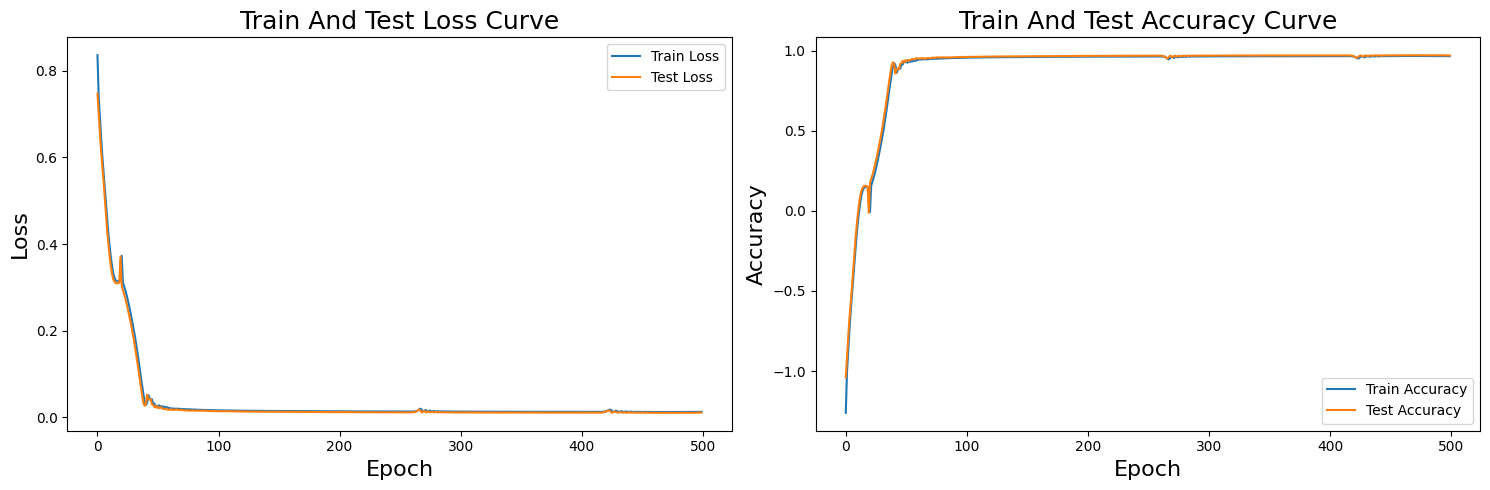

In [15]:
# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training loss
ax1.plot(train_loss, label='Train Loss')
ax1.plot(test_loss, label='Test Loss')
ax1.set_xlabel('Epoch',size=16)
ax1.set_ylabel('Loss',size=16)
ax1.set_title('Train And Test Loss Curve',size=18)
ax1.legend()

# Plot testing loss
ax2.plot(train_accuracy, label='Train Accuracy')
ax2.plot(test_accuracy, label='Test Accuracy')
ax2.set_xlabel('Epoch',size=16)
ax2.set_ylabel('Accuracy',size=16)
ax2.set_title('Train And Test Accuracy Curve',size=18)
ax2.legend()

plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import mean_squared_error

# Convert lists to NumPy arrays for convenience
y2_train_np = y2_train.numpy()
outputs_train_np = outputs_train.detach().numpy()

y3_test_np = y3_test.numpy()
outputs_test_np = outputs_test.detach().numpy()

# Calculate RMSE for training set
rmse_train = np.sqrt(mean_squared_error(y2_train_np, outputs_train_np))

# Calculate R-squared for training set
r2_train = r2_score(y2_train_np, outputs_train_np)

# Calculate RMSE for test set
rmse_test = np.sqrt(mean_squared_error(y3_test_np, outputs_test_np))

# Calculate R-squared for test set
r2_test = r2_score(y3_test_np, outputs_test_np)

# Print results
print('Training RMSE: {:.4f}, Training R-squared: {:.4f}'.format(rmse_train, r2_train))
print('Test RMSE: {:.4f}, Test R-squared: {:.4f}'.format(rmse_test, r2_test))

Training RMSE: 0.1127, Training R-squared: 0.9656
Test RMSE: 0.1045, Test R-squared: 0.9702


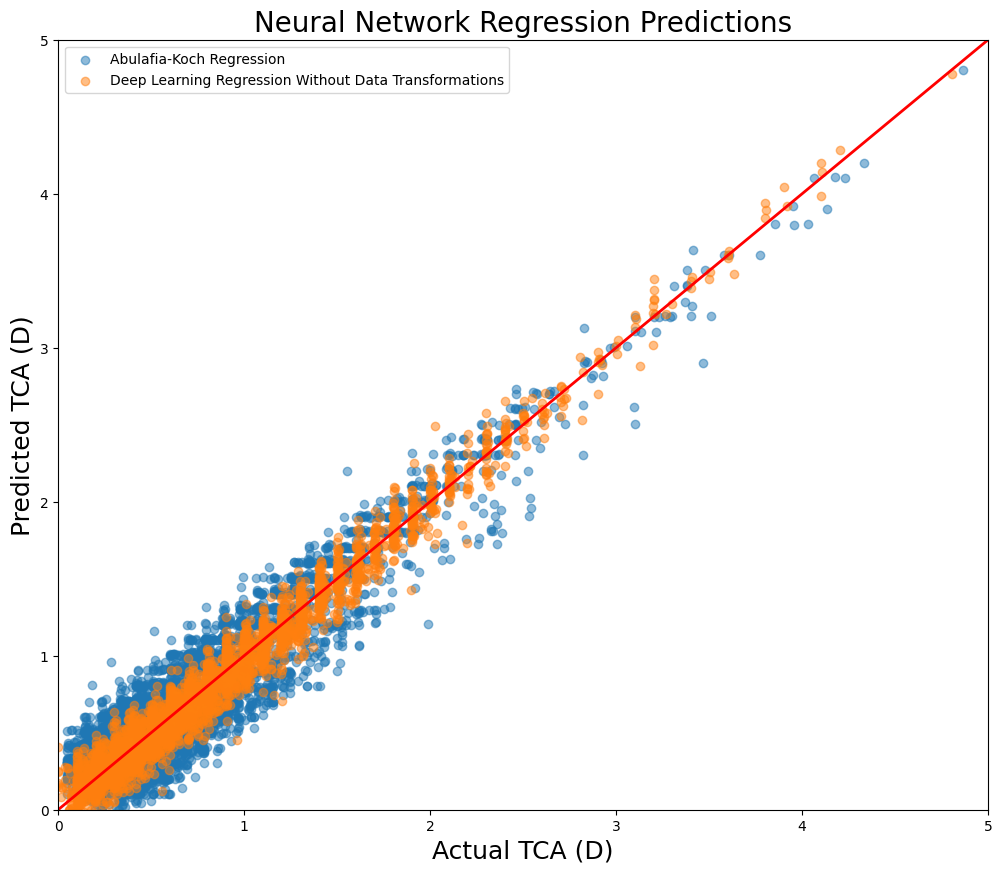

In [17]:
# get predicted values from the model
with torch.no_grad():
    predicted2 = model2(X3_test)

# convert tensor to numpy array
predicted2 = predicted2.numpy()

fig = plt.subplots(figsize=(12,10))

# plot actual vs predicted values
plt.scatter(ak_test['Total Corneal Cyl (reconstructed)'], ak_test['Astig Total (D):'], alpha=0.5, label='Abulafia-Koch Regression') # FOR AK
plt.scatter(y3_test, predicted2, alpha=0.5, label='Deep Learning Regression Without Data Transformations')

x_value = range(11)

# Calculate y values as equal to x
y_value = [val for val in x_value]

# Plot the line graph
plt.plot(x_value, y_value, color='#FF0000', linewidth=2)

#plt.axis('equal')
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('Actual TCA (D)',size=18)
plt.ylabel('Predicted TCA (D)',size=18)
plt.title('Neural Network Regression Predictions',size=20)
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


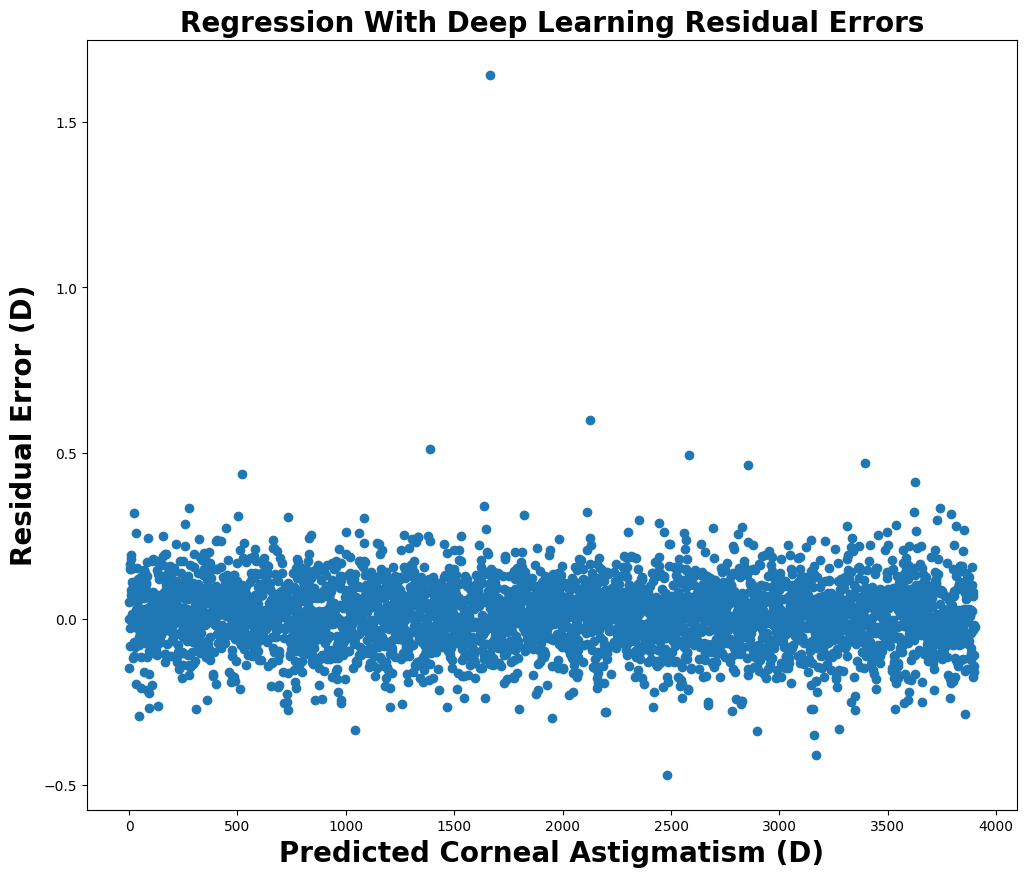

In [19]:
residuals = [y3_test[i] - predicted2[i] for i in range(len(y3_test))]
x_indices = range(len(y3_test))
fig = plt.subplots(figsize=(12,10))
plt.scatter(x_indices,residuals)
plt.xlabel('Predicted Corneal Astigmatism (D)',size=20, fontweight='bold')
plt.ylabel('Residual Error (D)',size=20, fontweight='bold')
plt.title('Regression With Deep Learning Residual Errors',size=20, fontweight='bold')
plt.show()

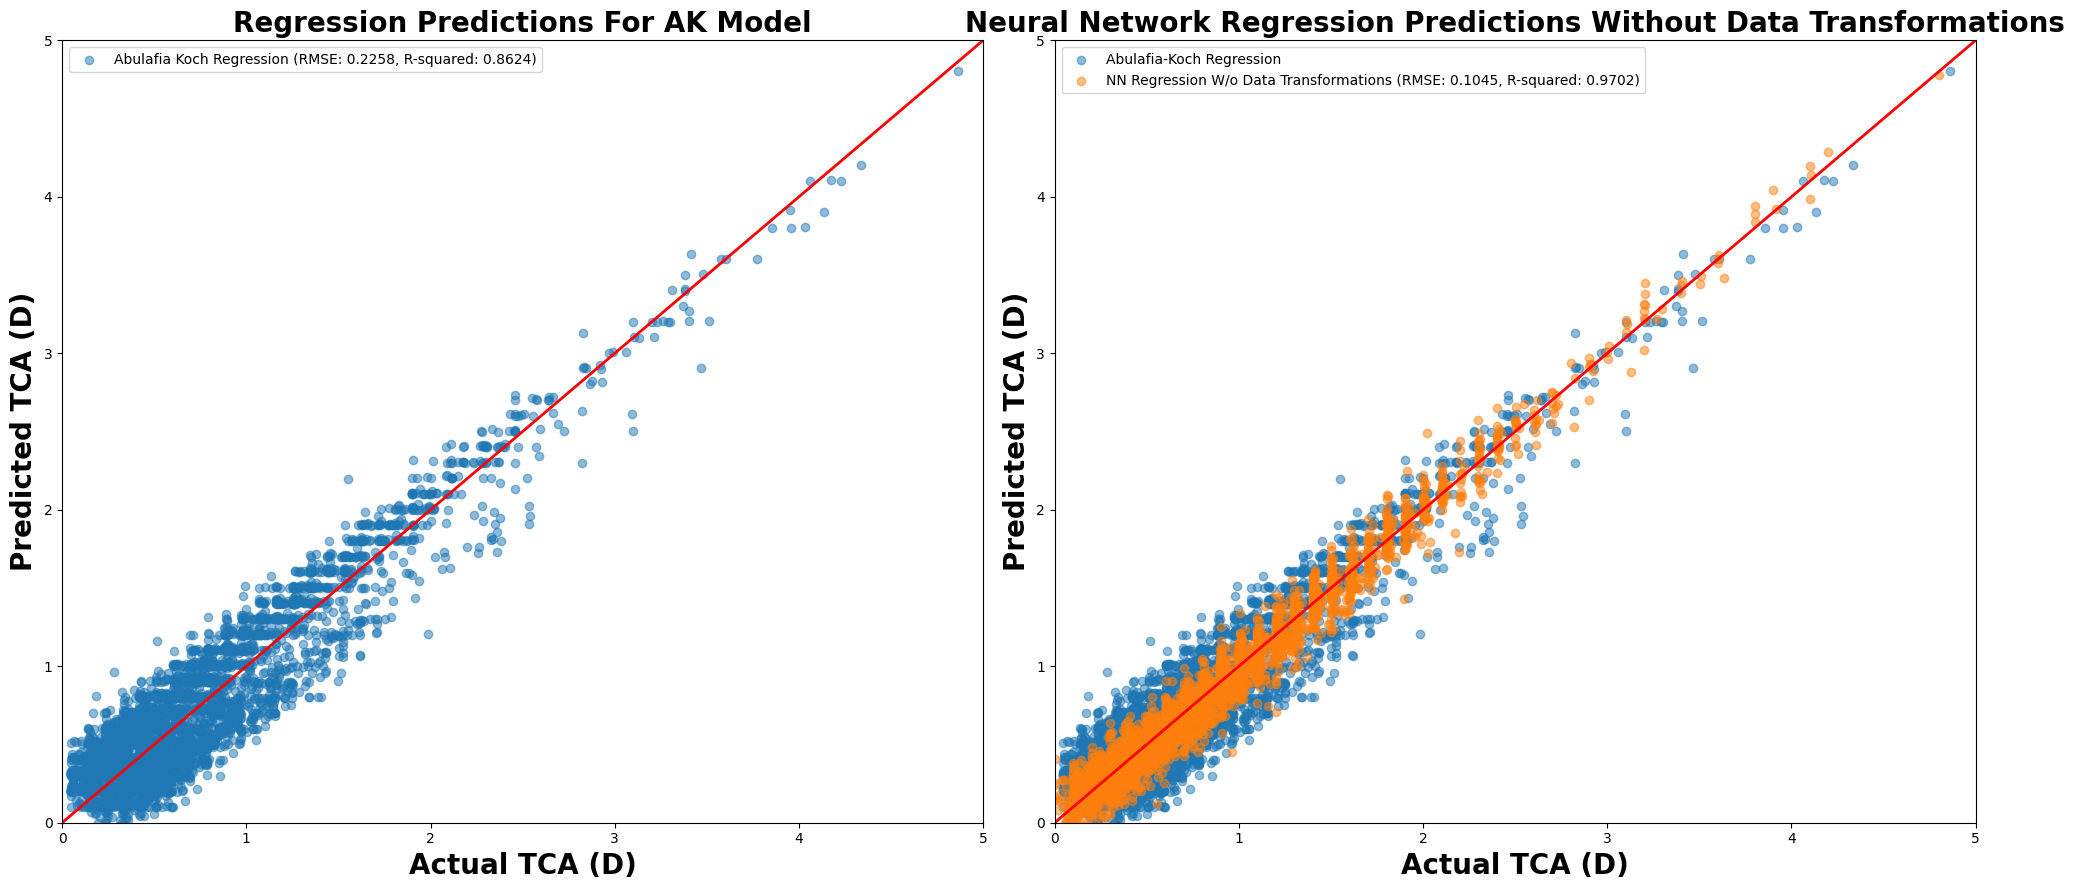

In [25]:
import matplotlib.pyplot as plt

legend_label2 = f"NN Regression W/o Data Transformations (RMSE: {rmse_test:.4f}, R-squared: {r2_test:.4f})"

# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 9))

# Plot the first scatter plot in the first subplot
axs[0].scatter(ak_test['Total Corneal Cyl (reconstructed)'], ak_test['Astig Total (D):'], alpha=0.5, label=legend_label) #AK DATA
#axs[0].scatter(df3['Astig F (D):'], df3['Astig Total (D):'], alpha=0.5, label='Deep Learning Regression') # OUR DATA
#axs[0].scatter(df2['F Mag'], df2['Astig Total (D):'], alpha=0.5, label='Humphrey Regression') # OUR DATA
x_value = range(11)
y_value = [val for val in x_value]
axs[0].plot(x_value, y_value, color='#FF0000', linewidth=2)
axs[0].set_xlim(0, 5)
axs[0].set_ylim(0, 5)
axs[0].set_xlabel('Actual TCA (D)', size=20, fontweight='bold')
axs[0].set_ylabel('Predicted TCA (D)', size=20, fontweight='bold')
axs[0].set_title('Regression Predictions For AK Model', size=20, fontweight='bold')
axs[0].legend()

# Plot the second scatter plot in the second subplot
axs[1].scatter(ak_test['Total Corneal Cyl (reconstructed)'], ak_test['Astig Total (D):'], alpha=0.5, label='Abulafia-Koch Regression') # FOR AK
axs[1].scatter(y3_test, predicted2, alpha=0.5, label=legend_label2)
x_value = range(11)
y_value = [val for val in x_value]
axs[1].plot(x_value, y_value, color='#FF0000', linewidth=2)
axs[1].set_xlim(0, 5)
axs[1].set_ylim(0, 5)
axs[1].set_xlabel('Actual TCA (D)', size=20, fontweight='bold')
axs[1].set_ylabel('Predicted TCA (D)', size=20, fontweight='bold')
axs[1].set_title('Neural Network Regression Predictions Without Data Transformations', size=20, fontweight='bold')
axs[1].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the combined plot
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


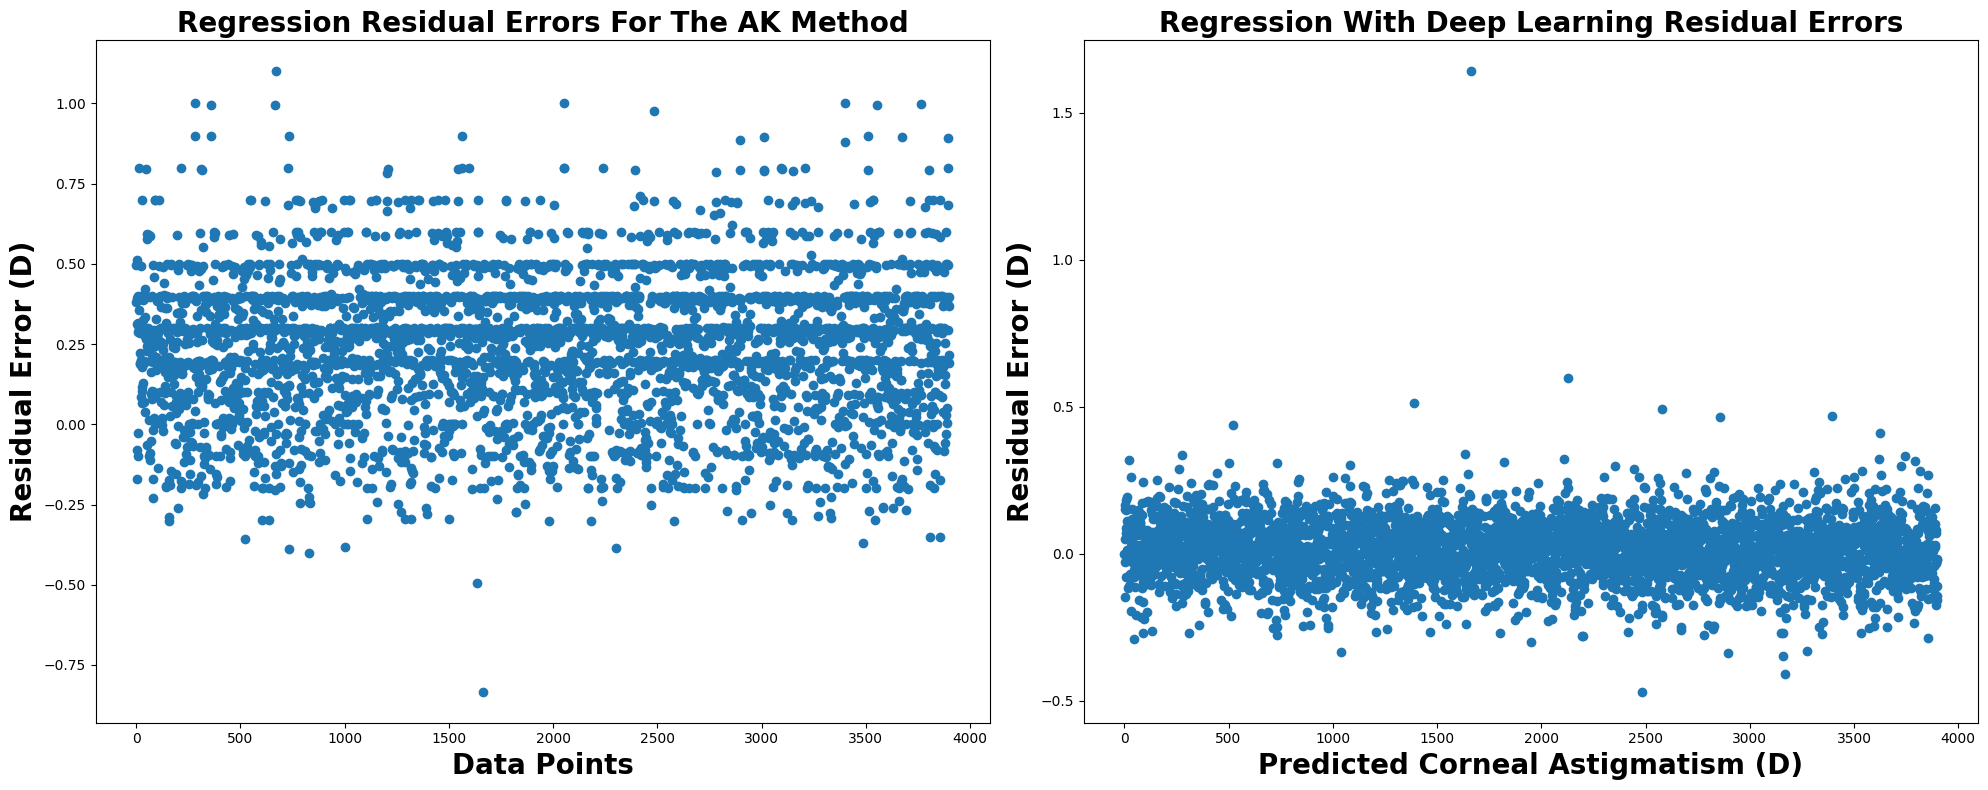

In [26]:
import matplotlib.pyplot as plt

# Residuals and x_indices for the AK method
residuals_ak = [ak_test['Astig F (D):'][i] - ak_test['Astig Total (D):'][i] for i in range(len(ak_test['Astig F (D):']))]
x_indices_ak = range(len(ak_test['Astig Total (D):']))

# Residuals and x_indices for deep learning
residuals_dl = [y3_test[i] - predicted2[i] for i in range(len(y3_test))]
x_indices_dl = range(len(y3_test))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot for AK method
axes[0].scatter(x_indices_ak, residuals_ak)
axes[0].set_xlabel('Data Points', size=20, fontweight='bold')
axes[0].set_ylabel('Residual Error (D)', size=20, fontweight='bold')
axes[0].set_title('Regression Residual Errors For The AK Method', size=20, fontweight='bold')

# Plot for deep learning
axes[1].scatter(x_indices_dl, residuals_dl)
axes[1].set_xlabel('Predicted Corneal Astigmatism (D)', size=20, fontweight='bold')
axes[1].set_ylabel('Residual Error (D)', size=20, fontweight='bold')
axes[1].set_title('Regression With Deep Learning Residual Errors', size=20, fontweight='bold')

plt.tight_layout()
plt.show()

In [32]:
average_residual_ak = np.mean(residuals_ak)

residuals_dl = y3_test_np - predicted2
x_indices_dl = range(len(y3_test_np))

# Calculate average residual error for deep learning
average_residual_dl = np.mean(residuals_dl)

average_residual_ak, average_residual_dl

(0.24676046872439167, 0.013180948)